In [7]:
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import stats
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sbn
import warnings
from fancyimpute import IterativeImputer
%matplotlib inline

Using TensorFlow backend.


## Data Imputation

We either need to impute values where they are missing or discard the feature from the model.  Given that the "Cabin" feature has a high degree of missingness and is complex, we will not bother imputing values, however we could come back to this feature later if we need to scrape a few more accuracy points out of the data.  We will also be dropping SibSp and Parch due to their double counting (a spouse will also have a count for their respective spouse, and so on).  Again, we could always come back to these features later to attempt some information gain, however we should first focus on the features with easily interpretable significance, such as Age and Embarked.

There are many ways to impute data, however we will be using an algorithm called [MICE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) to infer missing values in the Age, Embarked, and Fare categories.

In [2]:
train = pd.read_csv('../data/train.csv')  # load the training data
test = pd.read_csv('../data/test.csv')  # load the testing data
combined = pd.concat([train.drop('Survived', 1), test])  # remove the "Survived" column to combine them

combined.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**Note on Imputation in Python**

Python requires that all features be numeric or ordinal for imputing.  Therefore we need to only use the numeric or ordinal features and convert the categorical features into "one-hot encoding" or "dummy variables."  We will first drop the columns we won't use for imputation and then convert Embarked into a dummy variable for each category using Pandas.

In [5]:
# Drop columns not needed for imputation
combined_incomplete = combined.drop(['Cabin', 'PassengerId', 'SibSp', 'Parch',
                                    'Ticket', 'Name', 'Sex'], axis=1)
combined_incomplete2 = pd.get_dummies(combined_incomplete, columns=['Embarked'])
combined_incomplete2.head()

,Pclass,Age,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,7.2500,0,0,1
1,1,38.0,71.2833,1,0,0
2,3,26.0,7.9250,0,0,1
3,1,35.0,53.1000,0,0,1
4,3,35.0,8.0500,0,0,1


In [8]:
# Initialize the IterativeImputer with 100 iteration, sampling from the posterior, and a random seed
imputer = IterativeImputer(n_iter=100, sample_posterior=True, random_state=154)
combined_complete = pd.DataFrame(imputer.fit_transform(combined_incomplete2),
                                columns=['Pclass', 'Age', 'Fare', 'Embarked_C',
                                        'Embarked_Q', 'Embarked_S'])
combined_complete.head()

,Pclass,Age,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3.0,22.0,7.2500,0.0,0.0,1.0
1,1.0,38.0,71.2833,1.0,0.0,0.0
2,3.0,26.0,7.9250,0.0,0.0,1.0
3,1.0,35.0,53.1000,0.0,0.0,1.0
4,3.0,35.0,8.0500,0.0,0.0,1.0


In [9]:
# Check to ensure no data are missing
combined_complete.isnull().sum()

Pclass        0
Age           0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

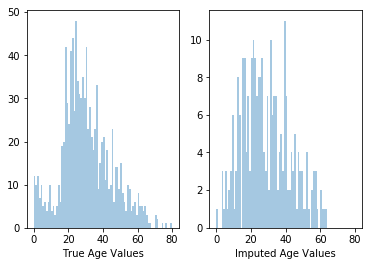

In [13]:
# Plot the imputed Age data to see if the distribution matches the original data
age_nulls = np.where(combined_incomplete2['Age'].isnull())[0]

plt.subplot(1, 2, 1)
sbn.distplot(combined['Age'].dropna().values, bins=range(0, 81, 1), 
            kde=False, axlabel='True Age Values')

plt.subplot(1, 2, 2)
sbn.distplot(combined_complete.loc[age_nulls, 'Age'], bins=range(0, 81, 1),
            kde=False, axlabel='Imputed Age Values')

## Feature Engineering

Given that many families or groups of acquainted people embarked on the Titanic, it is reasonable to assume that these groups wanted to stay together during the sinking event.  Therefore, having bought the same ticket or having the same last name may be a good indicator of survival or death for the entire group.  We can test this hypothesis by trying to identify groups of related people based on several of the features we already have: Pclass, Embarked, Fare, Ticket, and Cabin.  We will do this using the combined training and test set.

First, let's create a feature for Surname, since this can help us in engineering the GroupId feature later.  We will do this using regular expressions, which you can read about on this [DataCamp article](https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial).

In [15]:
import re

surname_regex = re.compile(r'(.+),')  # This pattern matches and extracts everything up to the first comma

# Iterate over the Names feature, extract the surname, store it in a new column called Surname
combined['Surname'] = np.array([surname_regex.match(x).group(1) for x in combined['Name']])
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


There are 875 unique surnames in the data


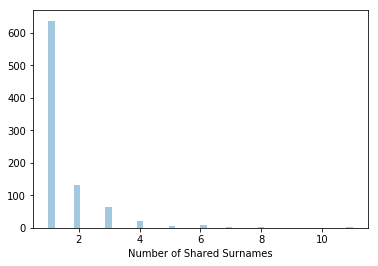

In [19]:
# How many people share a surname? Plot a histogram of unique surname counts.
surnames_uniques, surnames_counts = np.unique(combined['Surname'], return_counts=True)
print('There are {} unique surnames in the data'.format(len(surnames_uniques)))

sbn.distplot(surnames_counts, kde=False, axlabel='Number of Shared Surnames')

**Discovering patterns in the Ticket feature using Surname**

Do people share a last name?  How might be distinguish between these groups?  If they bought the same ticket, they likely are in the same family.  Let's count how many families have more than one unique ticket number.

In [21]:
# Unique tickets for family groups
num_detected = 0
for surname in surnames_uniques:
    unique_tickets = np.unique(combined[combined.Surname == surname]['Ticket'])
    if len(unique_tickets) > 1:
        num_detected += 1
        if num_detected <= 10:
            print(surname, sum(combined['Surname'] == surname), unique_tickets)
print('Total surnames with more than one unique ticket: {}'.format(num_detected))

Abelseth 2 ['348122' '348125']
Ali 2 ['SOTON/O.Q. 3101311' 'SOTON/O.Q. 3101312']
Allen 2 ['24160' '373450']
Andersson 11 ['3101281' '347075' '347082' '347091' '350043']
Andrew 2 ['231945' 'C.A. 34050']
Andrews 2 ['112050' '13502']
Asplund 8 ['347077' '350054']
Attalah 2 ['2627' '2694']
Betros 2 ['2622' '2648']
Bonnell 2 ['113783' '36928']
Total surnames with more than one unique ticket: 103


**Tickets are either similar or very different**

It appears that several families may have bought tickets close in number, for example the Ali family where the ticket numbers are off by one.  Alternatively, families that have very different ticket numbers probably were traveling separately or coincidentally share a last name, like the Asplunds.  We can better group families and those traveling together by removing the last digit of the Ticket feature.

In [22]:
# Get rid of last digit in ticket, store new values in TicketModified column
combined['TicketModified'] = np.array([x[:-1] for x in combined['Ticket']])
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,TicketModified
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,A/5 2117
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,PC 1759
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,STON/O2. 310128
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,11380
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,37345


**How did the TicketModified feature change the number of Surnames with more than one unique ticket?**

By removing the last digit, we expect the number of multi-ticket families to have dropped, which it did, as seen below.

In [24]:
# Unique modified tickets for a few family groups
num_detected = 0
for surname in surnames_uniques:
    unique_tickets = np.unique(combined[combined.Surname == surname]['TicketModified'])
    if len(unique_tickets) > 1:
        num_detected += 1
        if num_detected <= 10:
            print(surname, sum(combined['Surname'] == surname), unique_tickets)
print('Total surnames with more than one unique modified ticket: {}'.format(num_detected))

Allen 2 ['2416' '37345']
Andersson 11 ['310128' '34707' '34708' '34709' '35004']
Andrew 2 ['23194' 'C.A. 3405']
Andrews 2 ['11205' '1350']
Asplund 8 ['34707' '35005']
Attalah 2 ['262' '269']
Betros 2 ['262' '264']
Bonnell 2 ['11378' '3692']
Boulos 4 ['266' '267']
Bowen 2 ['5463' 'PC 1760']
Total surnames with more than one unique modified ticket: 87


**Families should have embarked from the same port**

We can leverage the port of embarkation to further discriminate between family groups that might coincidentally share a last name.  Let's first check how many Surname groups departed from different ports.

In [23]:
# Unique embarkation for a few family groups; we are interested in the gropus with more than 1 location
num_detected = 0
for surname in surnames_uniques:
    unique_ports = np.unique(combined[combined.Surname == surname]['Embarked'])
    if len(unique_ports) > 1:
        num_detected += 1
        if num_detected <= 10:
            print(surname, sum(combined['Surname'] == surname), unique_ports)

print('Total surnames with more than one unique port: {}'.format(num_detected))


Bowen 2 ['C' 'S']
Bradley 2 ['Q' 'S']
Brown 6 ['C' 'S']
Burns 2 ['C' 'Q']
Daly 3 ['Q' 'S']
Fleming 2 ['C' 'Q']
Flynn 3 ['Q' 'S']
Fox 2 ['Q' 'S']
Frauenthal 3 ['C' 'S']
Harper 4 ['C' 'S']
Total surnames with more than one unique port: 20


**Putting it all together to form a "unique" GroupId feature**

If we combine all of the previous observations into a new feature, that feature should allow us to group passengers by their traveling party.  We do this by simply concatenating the feature strings together using hyphens.  Note that because some features are numeric, we have to first make them strings using the map function.

In [29]:
# Use Pclass, Modified Ticket, Fare, and Embarked as an overall ID. Ignore cabin due to missingness.
combined['GroupId'] = combined['TicketModified'] + '-' + \
    combined['Pclass'].map(str) + '-' + \
    combined['Fare'].map(str) + '-' + \
    combined['Embarked']

num_identified = 0
for idgroup in np.unique(combined['GroupId'].map(str)):
    names = combined[combined.GroupId == idgroup]['Name']
    if len(names) > 1:
        num_identified += 1
        if num_identified <= 10:
            print(idgroup)
            for name in names:
                print('\t{}'.format(name))
print('A total of {} family/friend groups were putatively identified'.format(num_identified))

11015-1-86.5-S
	Cherry, Miss. Gladys
	Maioni, Miss. Roberta
	Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)
11041-1-79.65-S
	Taussig, Mr. Emil
	Taussig, Mrs. Emil (Tillie Mandelbaum)
	Taussig, Miss. Ruth
11046-1-52.0-S
	Porter, Mr. Walter Chamberlain
	Clifford, Mr. George Quincy
11081-1-75.25-C
	Warren, Mrs. Frank Manley (Anna Sophia Atkinson)
	Warren, Mr. Frank Manley
11136-1-57.9792-C
	Hippach, Miss. Jean Gertrude
	Hippach, Mrs. Louis Albert (Ida Sophia Fischer)
11142-1-26.55-S
	Romaine, Mr. Charles Hallace ("Mr C Rolmane")
	Bradley, Mr. George ("George Arthur Brayton")
11205-1-0.0-S
	Harrison, Mr. William
	Parr, Mr. William Henry Marsh
	Andrews, Mr. Thomas Jr
	Fry, Mr. Richard
	Chisholm, Mr. Roderick Robert Crispin
	Ismay, Mr. Joseph Bruce
11237-1-59.4-C
	Gibson, Mrs. Leonard (Pauline C Boeson)
	Gibson, Miss. Dorothy Winifred
11305-1-26.55-S
	Butt, Major. Archibald Willingham
	Daly, Mr. Peter Denis 
11305-1-47.1-S
	Carrau, Mr. Francisco M
	Carrau, Mr. Jose Pedro
A total of

**Check Passenger Titles**

The titles of the passengers could have errors or also could include interesting information about passenger importance.  Let's check the unique values of the titles using regular expressions.  Since the title always occurs right after the comma and always ends in a period, we can leverage that information.

In [26]:
# Check unique titles
title_regex = re.compile(r'.+, (.+)\. ')

titles = set()
for name in combined['Name']:
    matches = title_regex.match(name)
    if matches:
        titles.add(matches.group(1))
for t in titles:
    print(t)

Dr
Major
Capt
Don
Master
Lady
Col
Ms
Miss
Mrs
Mlle
the Countess
Mr
Rev
Mme
Dona
Sir
Jonkheer
Mrs. Martin (Elizabeth L


**Engineer a Title category**

From the above, it appears that several passengers have fancy titles, while there are also different ways of abbreviating Miss (Miss, Ms, Mlle) and Mrs (Mrs, Mme).  Additionally, it appears as though young male children were given the title Master.  The remaining titles are either ordinary like Mr. or rare, like Capt.  This could indicate importance and therefore could be a good feature.  Let's engineer this feature to fix the multi-category labels and group all rare titles together.

In [38]:
# Engineer the title feature and print the rare title names
new_title = []
for name in combined['Name']:
    if 'Mr.' in name:
        new_title.append('Mr')
    elif 'Master.' in name:
        new_title.append('Master')
    elif 'Miss.' in name or 'Mlle.' in name or 'Ms.' in name:
        new_title.append('Miss')
    elif 'Mrs.' in name or 'Mme.' in name:
        new_title.append('Mrs')
    else:
        print(name)
        new_title.append('Rare_Title')
        

combined['Title'] = np.array(new_title)
combined.head()

Uruchurtu, Don. Manuel E
Byles, Rev. Thomas Roussel Davids
Bateman, Rev. Robert James
Minahan, Dr. William Edward
Carter, Rev. Ernest Courtenay
Moraweck, Dr. Ernest
Pain, Dr. Alfred
Peuchen, Major. Arthur Godfrey
Butt, Major. Archibald Willingham
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")
Kirkland, Rev. Charles Leonard
Stahelin-Maeglin, Dr. Max
Simonius-Blumer, Col. Oberst Alfons
Frauenthal, Dr. Henry William
Weir, Col. John
Crosby, Capt. Edward Gifford
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)
Brewe, Dr. Arthur Jackson
Leader, Dr. Alice (Farnham)
Reuchlin, Jonkheer. John George
Harper, Rev. John
Montvila, Rev. Juozas
Gracie, Col. Archibald IV
Lahtinen, Rev. William
Peruschitz, Rev. Joseph Maria
Astor, Col. John Jacob
Dodge, Dr. Washington
Oliva y Ocana, Dona. Fermina


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,TicketModified,GroupId,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,A/5 2117,A/5 2117-3-7.25-S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,PC 1759,PC 1759-1-71.2833-C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,STON/O2. 310128,STON/O2. 310128-3-7.925-S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,11380,11380-1-53.1-S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,37345,37345-3-8.05-S,Mr


## Introductory Machine Learning Algorithms/Models:

### Assignments for the coming weeks

**Please do brief research on your classifier and attempt to implement it into Python or R. An example template notebook for sklearn will be sent out explaining cross-validation.**

 - RandomForest: Jared, Aerial
 - Linear Discriminant Analysis: Heather
 - Elastic Net: Amy
 - Support Vector Classifier: Shaun
 - AdaBoost: Jim
 - XGBoost: Jared
 - Neural Networks: Steven
 - k-Nearest Neighbors (supervised): Steven

We will be utilizing the engineered and imputed **train** dataset for cross-validation.  I have demonstrated how that was combined back together below.  This file will be available on GitHub.

In [39]:
# Create the complete train dataset
train2 = train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age'],
                   axis=1)
temp = combined_complete.loc[:train.shape[0],['Age',
                                              'Embarked_C',
                                              'Embarked_S',
                                              'Embarked_Q']]
temp2 = combined.iloc[0:891,:]
temp3 = pd.get_dummies(temp2.loc[:,  ['Title']])

train_complete = pd.concat((train2, 
                           temp,
                          temp3), axis=1)

train_complete = train_complete.drop(891, axis=0)

train_complete['Sex_Female'] = [1.0 if x == 'female' else 0.0 for x in train_complete['Sex']]

train_complete = train_complete.drop('Sex', axis=1)

train_complete.to_csv('../data/train_complete.csv')

train_complete.head()

,Survived,Pclass,Fare,Age,Embarked_C,Embarked_S,Embarked_Q,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Title,Sex_Female
0,0.0,3.0,7.2500,22.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,71.2833,38.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,3.0,7.9250,26.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,53.1000,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,3.0,8.0500,35.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
